# 4. Data Exploration for the CCPD 2019 dataset


In this notebook, we will take a look at the [Chinese City Parking Dataset](https://github.com/detectRecog/CCPD) which will be used for text detection and text recognition with [PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR). Then, we will prepare the annotation files in PaddleOCR format for text detection and spotting. Lastly, the images are cropped to be used in text recognition.

**Table of Contents**

1. [Mount Google Drive](#mount-google-drive)
1. [Chinese City Parking Dataset](#chinese-city-parking-dataset)
1. [Prepare data for PaddleOCR Text Detection or Spotting](#prepare-data-for-paddleocr-text-detection-or-spotting)
1. [Crop Word Image for PaddleOCR Text Recognition](#crop-word-image-for-paddleocr-text-recognition)

Get your seatbelt on and let's get started! 🔥⭐


<a name="mount-google-drive"></a>
## Mount Google Drive

In [1]:
from google.colab import drive

drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd "/content/drive/My Drive"
%cd "CCPD2019"
!ls

/content/drive/My Drive
/content/drive/My Drive/CCPD2019
CCPD2019.zip


In [3]:
!apt-get install unzip
!unzip CCPD2019.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Archive:  CCPD2019.zip
   creating: train/
  inflating: train/0070462164751-86_95-272&443_402&508-408&505_268&515_270&453_410&443-0_0_7_5_28_31_31-177-11.jpg  
  inflating: train/00738026819924-91_90-374&456_552&513-559&521_362&518_372&445_569&448-0_0_30_29_28_32_29-133-8.jpg  
  inflating: train/00853687739464-88_93-370&449_540&516-546&510_376&516_379&459_549&453-0_0_22_32_30_26_12-115-68.jpg  
  inflating: train/00985632183908-91_82-313&526_495&586-503&592_321&585_309&517_491&524-0_0_30_27_30_33_31-84-33.jpg  
  inflating: train/0102370689655-89_92-314&476_499&548-506&541_311&541_316&478_511&478-0_0_2_20_33_33_26-113-33.jpg  
  inflating: train/0106142241379-90_87-247&476_474&539-473&537_262&537_256&471_467&471-0_0_20_31_21_31_30-54-8.jpg  
  inflating: train/0106609195402

<a name="chinese-city-parking-dataset"></a>
## Chinese City Parking Dataset

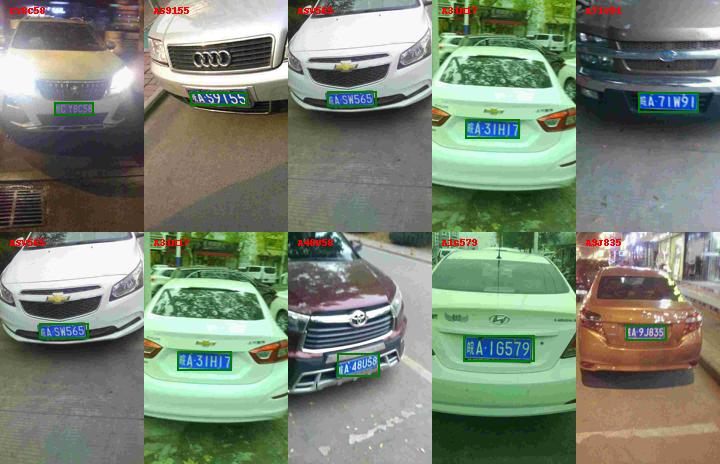

In [4]:
import os
import random
from PIL import Image, ImageDraw
import typing
from typing import List, Dict, Union

# Area: Area ratio of license plate area to the entire picture area.

# Tilt degree: Horizontal tilt degree and vertical tilt degree.

# Bounding box coordinates: The coordinates of the left-up and the right-bottom vertices.

# Four vertices locations: The exact (x, y) coordinates of the four vertices of LP in the whole image. These coordinates start from the right-bottom vertex.

# License plate number: Each image in CCPD has only one LP. Each LP number is comprised of a Chinese character, a letter, and five letters or numbers.
# A valid Chinese license plate consists of seven characters: province (1 character), alphabets (1 character), alphabets+digits (5 characters).
# "0_0_22_27_27_33_16" is the index of each character. These three arrays are defined as follows.
# The last character of each array is letter O rather than a digit 0.
# We use O as a sign of "no character" because there is no O in Chinese license plate characters.

# Brightness: The brightness of the license plate region.

# Blurriness: The Blurriness of the license plate region.


def image_grid(
    imgs: List[Dict[str, Union[Image.Image, str, List]]], rows: int, cols: int
):
    """Draw a grid of imgs

    Args:
        imgs (List[Dict[str, Union[Image.Image, str]]]): A list of dictionary with 'img', 'label', 'bbox' as keys.
        rows (int): Number of rows of the grid
        cols (int): Number of columns of the grid

    Returns:
        grid (Image.Image): A grid of images with annotation
    """

    assert len(imgs) == rows * cols

    text_offset = 10
    w, h = imgs[0]["img"].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    draw = ImageDraw.Draw(grid)

    for i, img in enumerate(imgs):
        img_left_up_x = i % cols * w
        img_left_up_y = i // cols * h
        grid.paste(img["img"], box=(img_left_up_x, img_left_up_y))
        draw.text(
            (img_left_up_x + text_offset, img_left_up_y + text_offset / 2),
            img["label"][1:],  # Default font can't decode Chinese characters, skip.
            fill=(255, 0, 0),
        )
        leftUp, rightDown = img["bbox"]
        draw.rectangle(
            [
                (leftUp[0] + img_left_up_x, leftUp[1] + img_left_up_y),
                (rightDown[0] + img_left_up_x, rightDown[1] + img_left_up_y),
            ],
            outline="green",
            width=2,
        )
    return grid


provinces = [
    "皖",
    "沪",
    "津",
    "渝",
    "冀",
    "晋",
    "蒙",
    "辽",
    "吉",
    "黑",
    "苏",
    "浙",
    "京",
    "闽",
    "赣",
    "鲁",
    "豫",
    "鄂",
    "湘",
    "粤",
    "桂",
    "琼",
    "川",
    "贵",
    "云",
    "藏",
    "陕",
    "甘",
    "青",
    "宁",
    "新",
    "警",
    "学",
    "O",
]
alphabets = [
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "J",
    "K",
    "L",
    "M",
    "N",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
    "O",
]
ads = [
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "J",
    "K",
    "L",
    "M",
    "N",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "O",
]

provNum, alphaNum, adNum = len(provinces), len(alphabets), len(ads)

img_path = "/content/drive/My Drive/CCPD2019/val"
all_files = os.listdir(img_path)
imgs = []
for i in range(10):
    downscale = 5
    img_name = random.sample(all_files, 1)[0]
    raw_img_name = os.path.splitext(os.path.basename(img_name))[0]

    # to parse license plate
    lbl = raw_img_name.split("-")[-3]
    lbl_list = [int(x) for x in lbl.split("_")]
    prov = [provinces[lbl_list[0]]]
    letter = [alphabets[lbl_list[1]]]
    alphanumeric = [ads[x] for x in lbl_list[2:]]
    full_lbl_str = "".join(x for x in prov + letter + alphanumeric)

    # to get bbox
    iname = raw_img_name.split("-")
    leftUp, rightDown = [
        [int(eel) / downscale for eel in el.split("&")] for el in iname[2].split("_")
    ]

    pil_img = Image.open(os.path.join(img_path, img_name))
    pil_img = pil_img.resize(
        (int(pil_img.size[0] / downscale), int(pil_img.size[1] / downscale))
    )

    i = {"label": full_lbl_str, "img": pil_img, "bbox": [leftUp, rightDown]}
    imgs.append(i)

grid = image_grid(imgs, 2, 5)
grid.show()

<a name="prepare-data-for-paddleocr-text-detection-or-spotting"></a>
## Prepare data for PaddleOCR Text Detection or Spotting

In [5]:
# The following is PaddleOCR Format for text detection or text spotting
# " Image file name             Image annotation information encoded by json.dumps"
# ch4_test_images/img_61.jpg    [{"transcription": "MASA", "points": [[310, 104], [416, 141], [418, 216], [312, 179]]}, {...}]

In [6]:
import os
import json
from tqdm import tqdm

alphabets = [
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "J",
    "K",
    "L",
    "M",
    "N",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
    "O",
]
ads = [
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "J",
    "K",
    "L",
    "M",
    "N",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "O",
]

root_path = "/content/drive/My Drive/CCPD2019/"
img_paths = [
    "/content/drive/My Drive/CCPD2019/train",
    "/content/drive/My Drive/CCPD2019/val",
]

for img_path in img_paths:
    split = img_path.split("/")[-1]
    all_files = os.listdir(img_path)

    with open(root_path + f"{split}.txt", mode="w") as out_f:
        out_str = []
        for img_name in tqdm(all_files):
            raw_img_name = os.path.splitext(os.path.basename(img_name))[0]

            # to parse license plate
            lbl = raw_img_name.split("-")[-3]
            lbl_list = [int(x) for x in lbl.split("_")]

            # exclude Chinese character
            letter = [alphabets[lbl_list[1]]]
            alphanumeric = [ads[x] for x in lbl_list[2:]]
            full_lbl_str = "".join(x for x in letter + alphanumeric)

            # to get bbox
            iname = raw_img_name.split("-")
            coords_1, coords_2, coords_3, coords_4 = [
                [int(eel) for eel in el.split("&")] for el in iname[3].split("_")
            ]
            current_dict = [
                {
                    "transcription": full_lbl_str,
                    "points": [coords_2, coords_3, coords_4, coords_1],
                }
            ]
            out_f.write(f"{os.path.basename(img_name)}\t{json.dumps(current_dict)}\n")

100%|██████████| 20/20 [00:00<00:00, 3246.99it/s]


<a name="crop-word-image-for-paddleocr-text-recognition"></a>
## Crop Word Image for PaddleOCR Text Recognition


In [7]:
# The following is PaddleOCR Format for text detection or text spotting
# " Image file name           Image annotation "
# train_data/rec/train/word_001.jpg   简单可依赖
# train_data/rec/train/word_002.jpg   用科技让复杂的世界更简单

In [8]:
import os
from PIL import Image
from tqdm import tqdm

alphabets = [
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "J",
    "K",
    "L",
    "M",
    "N",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
    "O",
]
ads = [
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "J",
    "K",
    "L",
    "M",
    "N",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "O",
]

root_path = "/content/drive/My Drive/CCPD2019/"
img_paths = [
    "/content/drive/My Drive/CCPD2019/train",
    "/content/drive/My Drive/CCPD2019/val",
]

for img_path in img_paths:
    split = img_path.split("/")[-1]
    all_files = os.listdir(img_path)

    crop_out_path = os.path.join(root_path, f"{split}_crop")
    if not os.path.exists(crop_out_path):
        os.makedirs(crop_out_path)

    with open(root_path + f"{split}_rec.txt", mode="w") as out_f:
        out_str = []
        for img_name in tqdm(all_files):
            raw_img_name = os.path.splitext(os.path.basename(img_name))[0]

            # to parse license plate
            lbl = raw_img_name.split("-")[-3]
            lbl_list = [int(x) for x in lbl.split("_")]

            # exclude Chinese character
            letter = [alphabets[lbl_list[1]]]
            alphanumeric = [ads[x] for x in lbl_list[2:]]
            full_lbl_str = "".join(x for x in letter + alphanumeric)

            # to get bbox
            iname = raw_img_name.split("-")
            leftUp, rightDown = [
                [int(eel) for eel in el.split("&")] for el in iname[2].split("_")
            ]

            # crop image
            pil_img = Image.open(os.path.join(img_path, img_name))
            crop_img = pil_img.crop((leftUp[0], leftUp[1], rightDown[0], rightDown[1]))
            crop_img.save(os.path.join(crop_out_path, img_name))

            out_f.write(f"{os.path.basename(img_name)}\t{full_lbl_str}\n")

100%|██████████| 20/20 [00:00<00:00, 45.47it/s]
